In [1]:
import numpy as np
import pandas as pd

import torch

from gaussian_ring_grid_generator import GaussianRingSpaceTimeGrid
import encoder
import importlib
importlib.reload(encoder)

<module 'encoder' from '/home/prs392/codes/capstone/numerical-relativity-interpolation/dev/encoder_sr/encoder.py'>

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
spaceTimeContext = GaussianRingSpaceTimeGrid(
    n_space_grid = 32,
    n_time_grid = 5,
    space_min_x = -5,
    space_max_x = 5,
    time_min_t = 0.5,
    time_max_t = 2.5
)

/home/prs392/codes/capstone/numerical-relativity-interpolation/dev/encoder_sr/gaussian_ring_grid_generator.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(GaussianRing(self.space_grid.cpu(), i, i/2)).unsqueeze(0) for i in self.time_axis]


In [32]:
test_grid = GaussianRingSpaceTimeGrid(
    n_space_grid = 48,
    n_time_grid = 4,
    space_min_x = -5,
    space_max_x = 5,
    time_min_t = 0.75,
    time_max_t = 2.25
)

/home/prs392/codes/capstone/numerical-relativity-interpolation/dev/encoder_sr/gaussian_ring_grid_generator.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [33]:
def get_decimal_index(axis_values, value):
    closest_above = axis_values[axis_values >= value].min()
    closest_below = axis_values[axis_values <= value].max()
    index_below = np.where(axis_values == closest_below)[0][0]
    
    if closest_above == closest_below:
        return index_below
    
    return index_below + ((value - closest_below)/(closest_above - closest_below))

In [35]:
ts = []
xs = []
ys = []
zs = []

time_t = []
space_x = []
space_y = []
space_z = []

vals = []

for i in range(test_grid.values.shape[0]):
    t = get_decimal_index(spaceTimeContext.time_axis.cpu().numpy(), test_grid.time_axis[i].item())
    
    
    for j in range(test_grid.values.shape[2]):
        x = get_decimal_index(spaceTimeContext.space_axis.cpu().numpy(), test_grid.space_axis[j].item())
        
        
        for k in range(test_grid.values.shape[3]):
            y = get_decimal_index(spaceTimeContext.space_axis.cpu().numpy(), test_grid.space_axis[k].item())
            
            
            for l in range(test_grid.values.shape[4]):
                z = get_decimal_index(spaceTimeContext.space_axis.cpu().numpy(), test_grid.space_axis[l].item())
                
                ts.append(t)
                xs.append(x)
                ys.append(y)
                zs.append(z)
                
                time_t.append(test_grid.time_axis[i].item())
                space_x.append(test_grid.space_axis[j].item())
                space_y.append(test_grid.space_axis[k].item())
                space_z.append(test_grid.space_axis[l].item())
                
                vals.append(test_grid.values[i, 0, j, k, l].item())
    break

In [36]:
inps = np.array([ts, xs, ys, zs]).T
outs = np.array(vals)
inps.shape, outs.shape

((110592, 4), (110592,))

In [37]:
input_tensor = torch.Tensor(inps).unsqueeze(1)
output_tensor = torch.Tensor(outs).unsqueeze(1)
input_tensor.shape, output_tensor.shape

(torch.Size([110592, 1, 4]), torch.Size([110592, 1]))

In [38]:
from torch.utils.data import TensorDataset, DataLoader

test_dataset = TensorDataset(input_tensor,output_tensor) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=32768)

In [39]:
import torch.nn as nn

model = encoder.SR(1, 16, 5)

In [40]:
model.load_state_dict(torch.load('/scratch/prs392/capstone/checkpoints/encoder_sr/epoch=49.pt'))

<All keys matched successfully>

In [41]:
import tqdm

model.to(device)
model.eval()

outputs = []

running_loss = 0.0
for i, data in tqdm.tqdm(enumerate(test_dataloader, 0)):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward + backward + optimize
    output = model(spaceTimeContext.values, inputs)
#         print(inputs)
#         print(labels)
#     print(outputs.shape)
    
    outputs.append(output)


4it [01:00, 15.03s/it]


In [42]:
outputs[0].shape

torch.Size([32768, 1])

In [43]:
model_outputs = torch.cat(outputs, dim=0).squeeze(1).detach().cpu().numpy()

In [44]:
df = pd.DataFrame(list(zip(time_t, space_x, space_y, space_z, vals, list(model_outputs))), columns =['t', 'x', 'y', 'z', 'expected', 'predicted']) 

In [45]:
df['z'].unique(), df['t'].unique()

(array([-5.        , -4.78723383, -4.57446814, -4.36170197, -4.14893627,
        -3.9361701 , -3.72340417, -3.51063824, -3.2978723 , -3.08510637,
        -2.87234044, -2.65957451, -2.44680858, -2.23404264, -2.02127671,
        -1.80851066, -1.59574473, -1.38297868, -1.17021275, -0.95744681,
        -0.74468082, -0.53191489, -0.31914893, -0.10638298,  0.10638298,
         0.31914893,  0.53191489,  0.74468082,  0.95744681,  1.17021275,
         1.38297868,  1.59574473,  1.80851066,  2.02127671,  2.23404264,
         2.44680858,  2.65957451,  2.87234044,  3.08510637,  3.2978723 ,
         3.51063824,  3.72340417,  3.9361701 ,  4.14893627,  4.36170197,
         4.57446814,  4.78723383,  5.        ]),
 array([0.75]))

In [46]:
df[(np.isclose(df['t'], 0.75)) & (np.isclose(df['z'], -0.31914893))]

,t,x,y,z,expected,predicted
22,0.75,-5.0,-5.000000,-0.319149,0.0,-0.184272
70,0.75,-5.0,-4.787234,-0.319149,0.0,-0.180985
118,0.75,-5.0,-4.574468,-0.319149,0.0,-0.177697
166,0.75,-5.0,-4.361702,-0.319149,0.0,-0.174410
214,0.75,-5.0,-4.148936,-0.319149,0.0,-0.171122
...,...,...,...,...,...,...
110374,0.75,5.0,4.148936,-0.319149,0.0,-0.291501
110422,0.75,5.0,4.361702,-0.319149,0.0,-0.296288
110470,0.75,5.0,4.574468,-0.319149,0.0,-0.301075
110518,0.75,5.0,4.787234,-0.319149,0.0,-0.305862


In [47]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [48]:
subset = df[(np.isclose(df['t'], 0.75)) & (np.isclose(df['z'], -0.31914893))]

In [49]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=subset['x'], y=subset['y'], mode = 'markers', marker=dict(
        color=subset['expected'],
        size=12
    )),
    row=1, col=1
)

fig.show()

In [50]:
# subset = df[(np.isclose(df['t'], 1.86999989)) & (np.isclose(df['z'], 0.48387095))]
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=subset['x'], y=subset['y'], mode = 'markers', marker=dict(
        color=subset['predicted'],
        size=12
    )),
    row=1, col=1
)

fig.show()

In [51]:
subset['expected'].min(), subset['expected'].max(), subset['expected'].mean(), subset['expected'].std()

(0.0, 1.0535104274749756, 0.04417796962095737, 0.1776492857575863)

In [52]:
subset['predicted'].min(),subset['predicted'].max(),subset['predicted'].mean(),subset['predicted'].std()

(-0.3105873465538025,
 -0.10030694305896759,
 -0.16984121748504954,
 0.03997748066104339)

(array([368.,  48.,  52.,  16.,  16.,  32.,   8.,  16.,   8.,  12.,   8.,
          8.,   8.,  16.,   8.,   8.,   0.,   8.,   0.,   8.,   0.,   8.,
          8.,  12.,   0.,  16.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,
          0.,   8.,   0.,  12.,   0.,   0.,  16.,   0.,   8.,   0.,   0.,
          0.,  16.,   0.,  12.,   0.,   0.,   0.,   0.,   0.,   0.,  12.,
          0.,   8.,   0.,   0.,   8.,   0.,  24.,   0.,   0.,   0.,   0.,
          8.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,  16.,   0.,   4.,
          0.,   8.,  12.,   0.,   8.,   0.,   8.,   8.,   0.,   0.,   0.,
          8.,   0.,   8.,   8.,   0.,  16.,   0.,  16.,  12.,   4.,  16.,
         24.]),
 array([7.38118473e-08, 4.26543659e-03, 8.53079936e-03, 1.27961621e-02,
        1.70615249e-02, 2.13268877e-02, 2.55922505e-02, 2.98576132e-02,
        3.41229760e-02, 3.83883388e-02, 4.26537016e-02, 4.69190644e-02,
        5.11844271e-02, 5.54497899e-02, 5.97151527e-02, 6.39805155e-02,
        6.82458782e-02, 7.2511

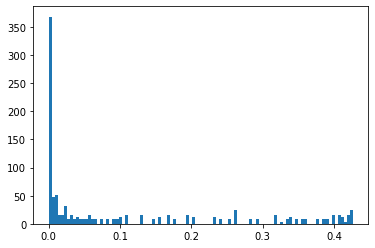

In [30]:
import matplotlib.pyplot as plt

plt.hist(subset['expected'], bins=100)

(array([ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  2.,  1.,  1.,  1.,  4.,  0.,
         2.,  1.,  3.,  2.,  1.,  3.,  2.,  3.,  1.,  4.,  3.,  2.,  2.,
         6.,  2.,  3.,  3.,  6.,  0.,  7.,  3.,  4.,  2.,  8.,  2.,  4.,
         5.,  7.,  2.,  9.,  3.,  5.,  6.,  8.,  4.,  6.,  7.,  7.,  4.,
        11.,  7.,  8.,  9., 12., 12., 10., 32., 21., 23., 32., 20., 30.,
        19., 31., 20., 23., 28., 20., 19., 26., 17., 21., 24., 16., 23.,
        24., 23., 18., 23., 22., 20., 14., 24., 17., 10., 29., 13., 11.,
        26.,  7., 11., 16.,  6., 11.,  9.,  4.,  6.]),
 array([-0.27760169, -0.27548251, -0.27336333, -0.27124415, -0.26912497,
        -0.26700579, -0.26488661, -0.26276743, -0.26064825, -0.25852907,
        -0.25640989, -0.25429071, -0.25217153, -0.25005235, -0.24793317,
        -0.24581399, -0.24369481, -0.24157563, -0.23945645, -0.23733727,
        -0.23521809, -0.23309891, -0.23097973, -0.22886055, -0.22674137,
        -0.22462219, -0.22250301, -0.22038383, -0.21826465, -0.216145

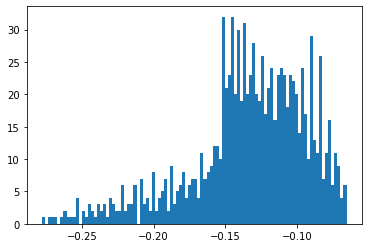

In [31]:
plt.hist(subset['predicted'], bins=100)